**Preprocessing: drop outliers + scale pain signature responses + filter missing data**

In [1]:
import fig02to05 as src
import pandas as pd

pd.set_option("display.float_format", "{:.4f}".format)


id_cols = ["sub", "task", "group", "study"]
vas_cols = ["int", "unp"]
psr_cols = ["nps", "siips", "na-gen", "na-therm", "na-mech", "na-sound", "na-vis"]

# study1: blood oxygen level dependent imaging
bold = (
    pd.read_csv("../../results/bold-ps-agg.csv")
    .assign(study="bold")
    .pipe(src.scale, psr_cols)  # zscore
)

# study2: cerebral blood flow imaging
cbf = (
    pd.read_csv("../../results/cbf-ps-agg.csv")
    .assign(study="cbf")
    .query("task.str.endswith('49C') and group != 's'")  # select 49C runs, c-m-l groups
    .pipe(src.drop_outliers, "cbfQEI")  # -1.5 * IQR on CBF quality index
    .pipe(src.scale, psr_cols)  # zscore
)

# study1 + study2: pain signature responses
psr = (
    pd.concat([bold[id_cols + vas_cols + psr_cols], cbf[id_cols + vas_cols + psr_cols]])
    .groupby("sub")  # filter missing data
    .filter(lambda x: {"preManip49C", "postManip49C"}.issubset(x["task"]))
)

psr.groupby(["group", "study"])["sub"].nunique()


group  study
c      bold     20
       cbf      19
l      cbf      19
m      bold     20
       cbf      17
Name: sub, dtype: int64

**Fig02: pain ratings**

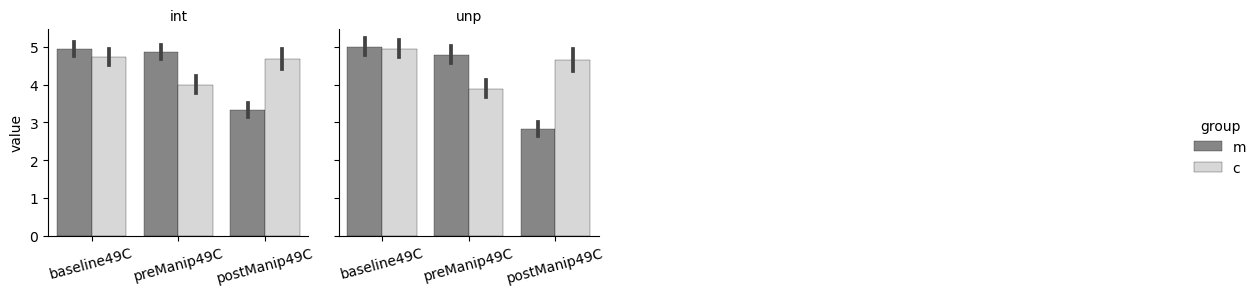

In [2]:
# subset dataframe + assign reference categories
tasks, groups = ["preManip49C", "postManip49C", "baseline49C"], ["m", "c"]

fig02 = (
    psr.query("task.isin(@tasks) and group.isin(@groups)")
    .assign(
        task=lambda x: pd.Categorical(x["task"], tasks, ordered=True),
        group=lambda x: pd.Categorical(x["group"], groups, ordered=True),
    )
    .melt(id_vars=id_cols, value_vars=vas_cols)
)

# plot bargraphs
src.plot_group_by_manipulation(
    fig02,
    var_order=vas_cols,
    task_order=["baseline49C", "preManip49C", "postManip49C"],
    group_order=["m", "c"],
).savefig("../../figures/fig02-pain-ratings.png", dpi=300)


# fit mixed linear models
(
    fig02.groupby("variable")
    .apply(src.fit_mixedlm, formula="value ~ group * task + study")
    .groupby(level=1)
    .apply(src.multicomp_fdr)
    .style.applymap(lambda fdr: "background-color: lightblue" if fdr < 0.05 else "", subset="qFDR")
)


**Fig03: pain signature responses**

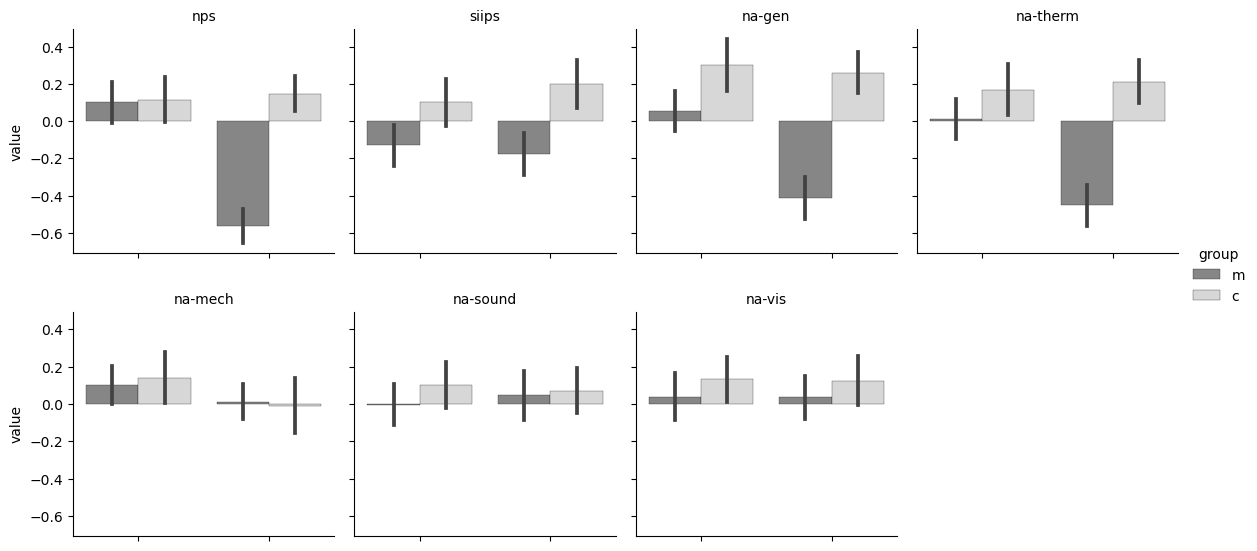

In [3]:
# subset dataframe + assign reference categories
tasks, groups = ["preManip49C", "postManip49C"], ["m", "c"]

fig03 = (
    psr.query("task.isin(@tasks) and group.isin(@groups)")
    .assign(
        task=lambda x: pd.Categorical(x["task"], tasks, ordered=True),
        group=lambda x: pd.Categorical(x["group"], groups, ordered=True),
    )
    .melt(id_vars=id_cols, value_vars=psr_cols)
)

# plot bargraphs
src.plot_group_by_manipulation(
    fig03,
    var_order=None,
    task_order=["preManip49C", "postManip49C"],
    group_order=["m", "c"],
).savefig("../../figures/fig03-pain-signature-responses.png", dpi=300)

# fit mixed linear models
(
    fig03.groupby("variable")
    .apply(src.fit_mixedlm, formula="value ~ group * task + study")
    .groupby(level=1)
    .apply(src.multicomp_fdr)
    .style.applymap(lambda fdr: "background-color: lightblue" if fdr < 0.05 else "", subset="qFDR")
)


**Fig04: pain ratings vs pain signature responses**

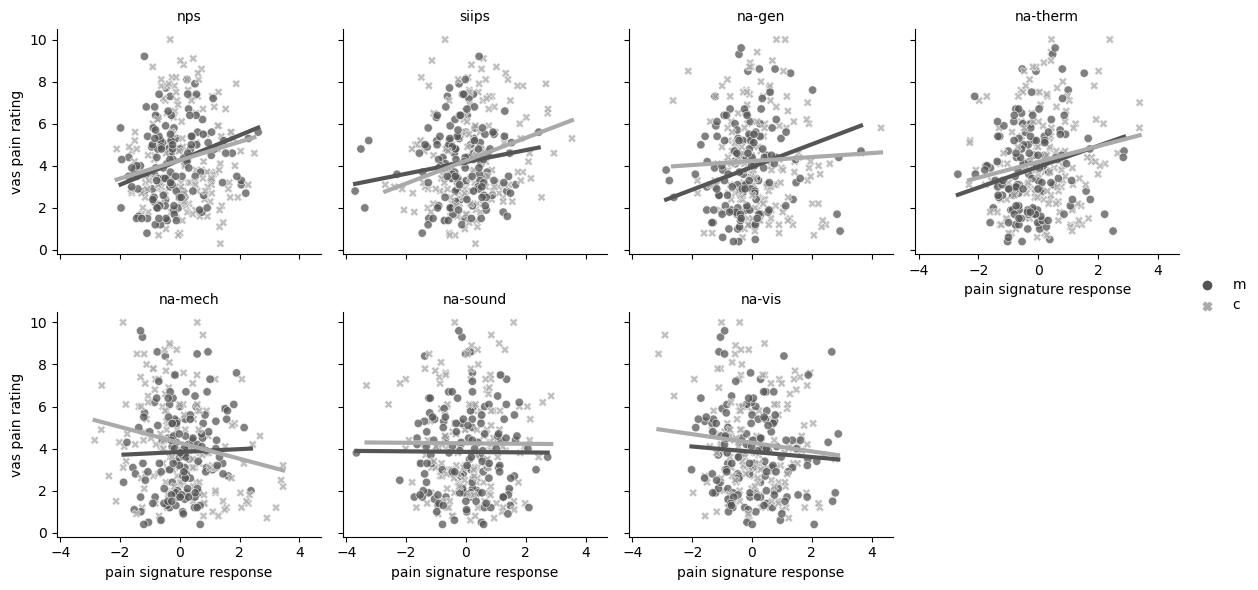

In [4]:
# subset dataframe + assign reference categories
tasks, groups = ["preManip49C", "postManip49C"], ["m", "c"]

fig04 = (
    psr.query("task.isin(@tasks) and group.isin(@groups)")
    .assign(group=lambda x: pd.Categorical(x["group"], groups, ordered=True))
    .melt(id_vars=id_cols + vas_cols, value_vars=psr_cols)
)

# plot regression lines
src.plot_mixedlm(fig04, var_order=psr_cols).savefig(
    "../../figures/fig04-pain-ratings-vs-pain-signature-responses.png", dpi=300
)

# fit mixed linear models
(
    fig04.groupby("variable")
    .apply(
        lambda x: src.fit_mixedlm(
            x, formula=f"{'unp' if 'na' in x.name else 'int'} ~ value*group + study"
        )
    )
    .groupby(level=1)
    .apply(src.multicomp_fdr)
    .style.applymap(lambda fdr: "background-color: lightblue" if fdr < 0.05 else "", subset="qFDR")
)


**Fig05: mindfulness meditation vs placebo cream**

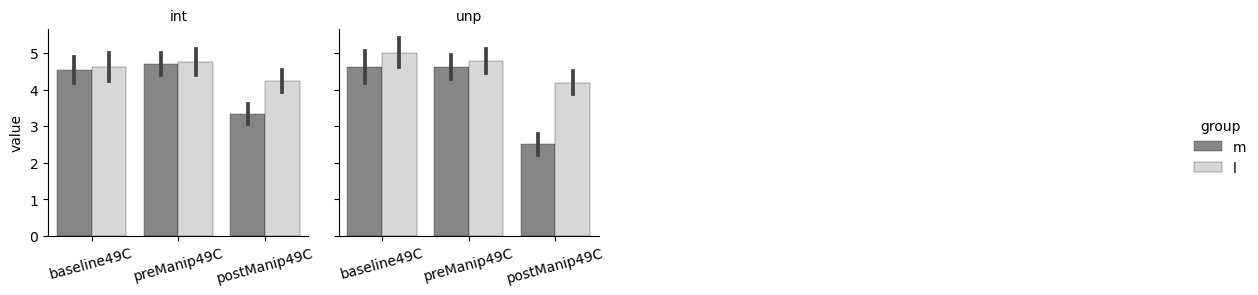

In [5]:
# subset dataframe + assign reference categories
tasks, groups = ["preManip49C", "postManip49C", "baseline49C"], ["l", "m"]

fig05a = (
    psr.query("task.isin(@tasks) and group.isin(@groups) and study == 'cbf'")
    .assign(
        task=lambda x: pd.Categorical(x["task"], tasks, ordered=True),
        group=lambda x: pd.Categorical(x["group"], groups, ordered=True),
    )
    .melt(id_vars=id_cols, value_vars=vas_cols)
)

# plot bargraphs
src.plot_group_by_manipulation(
    fig05a,
    var_order=None,
    task_order=["baseline49C", "preManip49C", "postManip49C"],
    group_order=["m", "l"],
).savefig("../../figures/fig05a-mindfulness-vs-placebo-pain-ratings.png", dpi=300)

# fit mixed linear models
(
    fig05a.groupby("variable")
    .apply(src.fit_mixedlm, formula="value ~ group * task")
    .groupby(level=1)
    .apply(src.multicomp_fdr)
    .style.applymap(lambda fdr: "background-color: lightblue" if fdr < 0.05 else "", subset="qFDR")
)


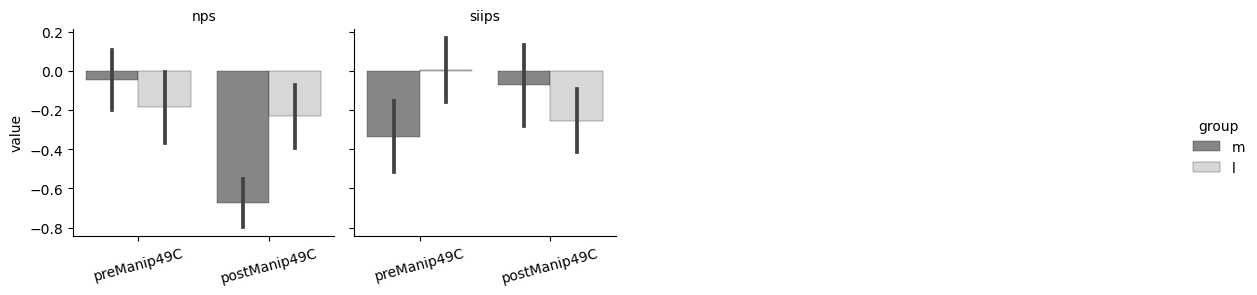

In [6]:
# subset dataframe + assign reference categories
tasks, groups = ["preManip49C", "postManip49C"], ["l", "m"]

fig05b = (
    psr.query("task.isin(@tasks) and group.isin(@groups) and study == 'cbf'")
    .assign(
        task=lambda x: pd.Categorical(x["task"], tasks, ordered=True),
        group=lambda x: pd.Categorical(x["group"], groups, ordered=True),
    )
    .melt(id_vars=id_cols, value_vars=["nps", "siips"])
)

# plot bargraphs
src.plot_group_by_manipulation(
    fig05b,
    var_order=None,
    task_order=["preManip49C", "postManip49C"],
    group_order=["m", "l"],
).savefig("../../figures/fig05b-mindfulness-vs-placebo-pain-signature-responses.png", dpi=300)

# fit mixed linear models
(
    fig05b.groupby("variable")
    .apply(src.fit_mixedlm, formula="value ~ group * task")
    .groupby(level=1)
    .apply(src.multicomp_fdr)
    .style.applymap(lambda fdr: "background-color: lightblue" if fdr < 0.05 else "", subset="qFDR")
)
